In [10]:
import csv
import json
import copy
import string
import random
from tqdm.auto import tqdm
from itertools import combinations, product

import networkx as nx
import plotly.express as px
from plotly.graph_objs import *

In [2]:
class InputExample(object):
    def __init__(self, text_a, text_b, label):
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
    def __repr__(self):
        return str(self.to_json_string())
    
    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

    
def read_examples(filename):
    examples = []
        
    with open(filename) as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue

            q1 = row[0]
            q2 = row[1]
            label = row[2]

            examples.append(InputExample(q1, q2, label))
            
    return examples

In [351]:
def dataset_statistics(filename):
    examples = read_examples(filename)
    
    paraphrase_count = sum([1 for e in examples if e.label == '1'])
    non_paraphrase_count = sum([1 for e in examples if e.label == '0'])
    return paraphrase_count, non_paraphrase_count

In [371]:
examples = read_examples('data/train.tsv')

G = nx.Graph()

for e in examples:
    G.add_edge(e.text_a, e.text_b, is_duplicate=int(e.label))

In [558]:
subgraphs = []

for nodes in nx.connected_components(G):
    if len(nodes) < 4 or len(nodes) > 7:
        continue
        
    graph = G.subgraph(nodes)
    edge_labels = [e[2]['is_duplicate'] for e in graph.edges(data=True)]
    type_of_edges = set(edge_labels)
    `
    if len(type_of_edges) == 1:
        continue
    if sum(edge_labels) < 3:
        continue
        
    groups, group_attr = find_groups(graph)
    flag = False
    for n in groups.values():
        if len(n) == 1:
            flag = True
            break
    if flag:
        continue
    
    subgraphs.append(graph)

In [784]:
import string
import matplotlib.pyplot as plt


def find_groups(graph):
    groups = {}
    group_attr = {}
    g = graph.copy()
    
    for u, v, d in graph.edges(data=True):
        if d['is_duplicate'] == 0:
            g.remove_edge(u,v)
    
    for i, nodes in enumerate(nx.connected_components(g)):
        groups[i] = list(nodes)
        group_attr.update({n: {'group': i} for n in nodes})
        
    return groups, group_attr

def plot_graph(graph, pos):
    pos_edges = [(u, v) for (u, v, d) in graph.edges(data=True) if d['is_duplicate'] == 1]
    neg_edges = [(u, v) for (u, v, d) in graph.edges(data=True) if d['is_duplicate'] == 0]

#     pos = nx.spring_layout(graph)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_color='white', 
                           edgecolors=['black' for _ in range(graph.number_of_nodes())], 
                           label=None)

    # edges
    nx.draw_networkx_edges(graph, pos, edgelist=pos_edges, label='paraphrase')
    nx.draw_networkx_edges(graph, pos, edgelist=neg_edges, style='dashed', label='non-paraphrase')
    
    labels = {node: label for node, label in zip(graph.nodes(), string.ascii_uppercase[:len(graph.nodes())])}
    
    for n, x in labels.items():
        print('{}: {}'.format(x, n))
        
    # labels
    nx.draw_networkx_labels(graph, pos, labels=labels, loc='best')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()


def plot_inferred_graph(graph):
    
    pos_edges = [(u, v) for (u, v, d) in graph.edges(data=True) if 'is_duplicate' in d and d['is_duplicate'] == 1]
    neg_edges = [(u, v) for (u, v, d) in graph.edges(data=True) if 'is_duplicate' in d and d['is_duplicate'] == 0]
    
    
    groups, group_attr = find_groups(graph)
    nx.set_node_attributes(graph, group_attr)
    
    inferred_edges = []
    for nodes in groups.values():
        inferred_edges.extend([(x, y, 1) for x, y in combinations(nodes, 2)])
        
    non_paraphrase_groups = set()
    for u, v, d in graph.edges(data=True):
        if d['is_duplicate'] == 1:
            continue
        
        if u not in group_attr or v not in group_attr:
            continue
        group_1 = group_attr[u]['group']
        group_2 = group_attr[v]['group']
        if group_1 != group_2:
            non_paraphrase_groups.add(tuple(sorted([group_1, group_2])))
            
    for g1, g2 in non_paraphrase_groups:
        inferred_edges.extend([(x, y, 0) for x, y in list(product(groups[g1], groups[g2]))])
    
    remove = []
    for u, v, d in inferred_edges:
        if graph.has_edge(u,v):
            remove.append((u,v,d))
    
    inferred_edges = [x for x in inferred_edges if x not in remove]
    
    new_graph = graph.copy()
    
    for x, y, label in inferred_edges:
        new_graph.add_edge(x, y, is_duplicate=label)
        
    pos = nx.spring_layout(new_graph)

    # nodes
    nx.draw_networkx_nodes(new_graph, pos, node_color='white', 
                           edgecolors=['black' for _ in range(graph.number_of_nodes())], 
                           label=None)

    # edges
    nx.draw_networkx_edges(new_graph, pos, edgelist=pos_edges, label='paraphrase')
    nx.draw_networkx_edges(new_graph, pos, edgelist=neg_edges, style='dashed', label='non-paraphrase')

    infer_pos = [(u, v) for (u, v, d) in inferred_edges if d == 1]
    infer_neg = [(u, v) for (u, v, d) in inferred_edges if d == 0]
    
    if len(infer_pos) > 0:
        nx.draw_networkx_edges(new_graph, pos, edgelist=infer_pos, 
                               label='inferred paraphrase', edge_color='blue')
    if len(infer_neg) > 0:
        nx.draw_networkx_edges(new_graph, pos, edgelist=infer_neg, style='dashed', 
                               label='inferred non-paraphrase', edge_color='blue')

    labels = {node: label for node, label in zip(new_graph.nodes(), string.ascii_uppercase[:len(new_graph.nodes())])}

    for n, x in labels.items():
        print('{}: {}'.format(x, n))

    # labels
    nx.draw_networkx_labels(new_graph, pos, labels=labels, loc='best')
#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#     plt.tight_layout()
    return pos

A: What does it feel like to become famous on Quora?
B: How do I become famous on Quora?
C: What is the best way to be famous on Quora?
D: What is it like to be famous on Quora?
E: What is it like to be popular on Quora?
F: What does it feel like to be famous on Quora?


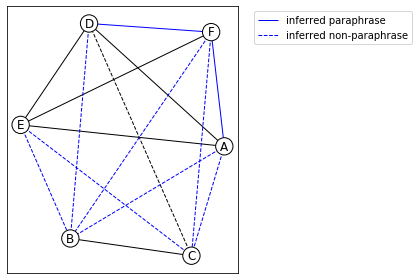

In [780]:
index = 102
pos = plot_inferred_graph(subgraphs[index])

A: What does it feel like to become famous on Quora?
B: How do I become famous on Quora?
C: What is the best way to be famous on Quora?
D: What is it like to be famous on Quora?
E: What is it like to be popular on Quora?
F: What does it feel like to be famous on Quora?


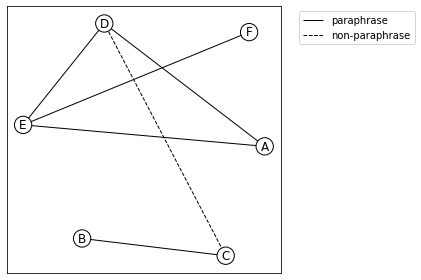

In [785]:
plot_graph(subgraphs[index], pos)

A: Does life exits on mars?
B: Is there life on Mars?
C: Is life possible in Mars?
D: Do you think there is life on Mars?
E: Is there any life in Mars?


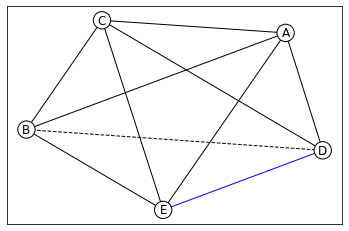

In [731]:
index = 63
pos = plot_inferred_graph(subgraphs[index])

A: Does life exits on mars?
B: Is there life on Mars?
C: Is life possible in Mars?
D: Do you think there is life on Mars?
E: Is there any life in Mars?


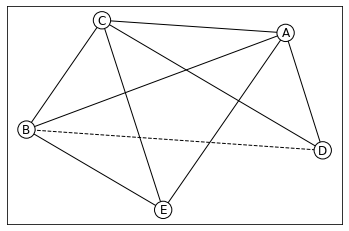

In [732]:
plot_graph(subgraphs[index], pos)

A: What was the funniest story you have heard?
B: What's the funniest story you've ever heard?
C: What is the scariest story you have ever heard?
D: What was the scariest story you ever heard?
E: What is the funniest story you ever heard?
F: What is the scariest you have ever heard or read?


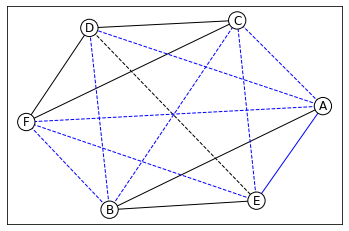

In [707]:
index = 42
pos = plot_inferred_graph(subgraphs[index])

A: What was the funniest story you have heard?
B: What's the funniest story you've ever heard?
C: What is the scariest story you have ever heard?
D: What was the scariest story you ever heard?
E: What is the funniest story you ever heard?
F: What is the scariest you have ever heard or read?


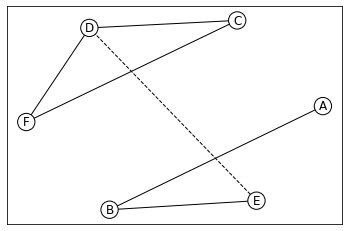

In [708]:
plot_graph(subgraphs[index], pos)

In [143]:
examples = read_examples('data/train.tsv')

# Find paraphrase clusters

g = nx.Graph()

for e in examples:
    if e.label == '1':
        g.add_edge(e.text_a, e.text_b)
        
group_attr = {}

for i, nodes in enumerate(nx.connected_components(g)):
    group_attr.update({n: {'group': i} for n in nodes})

In [144]:
G = nx.Graph()

for e in examples:
    G.add_edge(e.text_a, e.text_b, is_duplicate=int(e.label))
    
nx.set_node_attributes(G, group_attr)


nodes_to_remove = []

for n in G.nodes():
    edges = G.edges(n, data=True)
    type_of_edges = set([e[2]['is_duplicate'] for e in edges])
    
    # Remove nodes that only have non-paraphrase edges
    if len(type_of_edges) == 1 and type_of_edges.pop() == 0:
        nodes_to_remove.append(n)
        
G.remove_nodes_from(nodes_to_remove)

In [145]:
subgraphs = []

for nodes in nx.connected_components(G):
    graph = G.subgraph(nodes)
    type_of_edges = set([e[2]['is_duplicate'] for e in graph.edges(data=True)])
    
    # We only consider the subgraphs with both paraphrases and non-paraphrases
    if len(type_of_edges) == 2:
        subgraphs.append(graph)

In [7]:
def find_unbalance(graph):
    # Find mislabled edges (non-paraphrase edges within the paraphrase cluster)
    
    mislabeled_edges = []
    for n, attr in graph.nodes(data=True):
        if 'group' not in attr:
            continue
            
        edges = graph.edges(n, data=True)
        
        type_of_edges = set([e[2]['is_duplicate'] for e in edges])
        if len(type_of_edges) == 1:
            continue
            
        neg_edges = [e for e in edges if e[2]['is_duplicate'] == 0]
        
        for u, v, a in neg_edges:
            if 'group' not in graph.nodes[v]:
                continue
                
            if graph.nodes[v]['group'] == attr['group']:
                mislabeled_edges.append((u, v))
    
    
    if len(mislabeled_edges) == 0:
        return None
    
    mislabeled_edges = map(tuple,[sorted(i) for i in mislabeled_edges])
    mislabeled_edges = list(set(mislabeled_edges))
    return mislabeled_edges

In [146]:
unbalanced_subgraphs = []
mislabeled_pairs = {}

for graph in tqdm(subgraphs):
    unbalanced = find_unbalance(graph)
    if unbalanced:
#         if graph.number_of_nodes() < 20 or graph.number_of_nodes() > 30:
#             continue
        unbalanced_subgraphs.append(graph)
        mislabeled_pairs[len(mislabeled_pairs)] = unbalanced

In [147]:
len(unbalanced_subgraphs)

77

In [148]:
pairs = [x for pairs in mislabeled_pairs.values() for x in pairs]
len(pairs)

88

In [48]:
colorscale = px.colors.diverging.Spectral

def find_groups(graph):
    groups = {}
    group_attr = {}
    g = graph.copy()
    
    for u, v, d in graph.edges(data=True):
        if d['is_duplicate'] == 0:
            g.remove_edge(u,v)
    
    for i, nodes in zip(string.ascii_uppercase, nx.connected_components(g)):
        groups[i] = list(nodes)
        group_attr.update({n: i for n in nodes})
        
    return groups, group_attr


def plot(graph, mislabeled_edges):
    
    nodes = list(graph.nodes())
    
    groups, group_attr = find_groups(graph)
    
    sampled_colors = random.choices(colorscale, k=len(groups))
    colors = {g: c for g, c in zip(groups.keys(), sampled_colors)}
    node_colors = [colors[group_attr[n]] for n in graph.nodes()]
    
    if len(groups) == 1:
        node_labels = {node: label for node, label in zip(graph.nodes(), string.ascii_uppercase[:len(graph.nodes())])}
    else:
        node_labels = {node: '{}{}'.format(group_attr[node], groups[group_attr[node]].index(node)) for node in graph.nodes()}
    
    labels = list(node_labels.values())
    
    for i, x in groups.items():
        for n in x:
            print('{}: {}'.format(node_labels[n], n))
    
    
    pos = nx.spring_layout(graph)
    
    Xv=[pos[n][0] for n in nodes]
    Yv=[pos[n][1] for n in nodes]
    Xed_1, Yed_1 = [], []
    Xed_2, Yed_2 = [], []
    Xed_3, Yed_3 = [], []
    
    for u, v, attr in graph.edges(data=True):
        if (u,v) in mislabeled_edges or (v, u) in mislabeled_edges:
            continue
        if attr['is_duplicate'] == 1:
            Xed_1 += [pos[u][0], pos[v][0], None]
            Yed_1 += [pos[u][1], pos[v][1], None]
        else:
            Xed_2 += [pos[u][0], pos[v][0], None]
            Yed_2 += [pos[u][1], pos[v][1], None]
            
    for u, v in mislabeled_edges:
        Xed_3 += [pos[u][0], pos[v][0], None]
        Yed_3 += [pos[u][1], pos[v][1], None]
            
    node_trace = Scatter(x=Xv, 
                         y=Yv, 
                         mode='markers+text', 
                         marker=dict(symbol='circle-dot', 
                                     size=10, 
                                     color=node_colors, 
                                     line=dict(color='rgb(50,50,50)', width=0.5)), 
                         text=labels,
                         textposition='top center',
                         textfont_size=17,
                         showlegend=False
                        )
    
    # paraphrase edges
    edge_trace1 = Scatter(x=Xed_1, 
                          y=Yed_1, 
                          mode='lines', 
                          line=dict(color='gray', width=1), 
                          hoverinfo='none',
                          showlegend=True,
                          name='paraphrase'
                         )
    
    # non-paraphrase edges
    edge_trace2 = Scatter(x=Xed_2, 
                          y=Yed_2, 
                          mode='lines', 
                          line=dict(color='gray', width=1, dash='dash'), 
                          hoverinfo='none',
                          showlegend=True,
                          name='non-paraphrase'
                         )
    
    # mislabeled edges
    edge_trace3 = Scatter(x=Xed_3, 
                          y=Yed_3, 
                          mode='lines', 
                          line=dict(color='mediumvioletred', width=1, dash='dash'), 
                          hoverinfo='none',
                          showlegend=True,
                          name='conflicted'
                         )
    
    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False,
              showgrid=False,
              showticklabels=False,
              title='')
    
    layout = Layout(
        font= dict(size=12),
#         showlegend=False,
        autosize=False,
        width=800,
        height=600,
        xaxis=axis,
        yaxis=axis,
        margin=dict(l=5, r=5, b=20, t=40),
        hovermode='closest',
    )
    
    data = [edge_trace1, edge_trace2, edge_trace3, node_trace]
    
    fig = Figure(data=data, layout=layout)
    fig.show()

In [67]:
index = 38
plot(unbalanced_subgraphs[index], mislabeled_pairs[index])

A: What were the most happiest moments in your life?
B: What was the happiest moment in your life?
C: What are the happiest moments in your life?
D: What were some of your happiest moments in life?
E: What is your most happiest moment in life?
F: What is the most happiest moment in life?


In [105]:
index = 2
plot(unbalanced_subgraphs[index], mislabeled_pairs[index])

A0: What are some ways to delete my Yahoo Mail account permanently?
A1: How do you permantley delete a Yahoo e-mail account?
A2: What is the safest way to delete my Yahoo account?
A3: What is the best way to disable your Yahoo account permanently?
A4: How do you disable a Yahoo account?
A5: What are some ways to delete my Yahoo Mail account?
A6: How do you delete your Yahoo account permanently?
A7: How do you delete your Yahoo email account?
A8: How can you terminate your Yahoo e-mail account?
A9: How do I deactivate a Yahoo! account?
A10: How can you delete your Yahoo mail account?
A11: How can can I delete my yahoo email account?
A12: How can you delete your Yahoo account?
A13: How do you permanently delete your Yahoo account?
A14: How can I deactivate my yahoo account permanently?
A15: How can you delete your Yahoo Mail ID?
B0: How can I delete a Facebook messenger account (i.e. a mobile number-only account, with no password etc).
B1: How do I delete my Messenger account?
B2: How ca

In [86]:
index = 1
plot(unbalanced_subgraphs[index], mislabeled_pairs[index])

A: Can history repeat itself?
B: Will the history repeat itself?
C: Is history repeating itself?
D: What proves that history repeats itself?


In [33]:
index = 15
plot(unbalanced_subgraphs[index], mislabeled_pairs[index])

A0: What music app is free without wifi connection?
A1: What app for music without wifi for iPod?
A2: What are some free music apps to download whereby you can download music in the app itself and listen to the music when offline?
A3: Are there any music apps that I can listen to without needing an Internet connection?
A4: How can I listen to music offline without it stopping when I turn off the device or open up another app or tab?
A5: What app allows you to listen to music without WiFi or Internet?
B0: What is the best music app for the iOS where you don't need internet to use?
B1: What app allows you to listen to music without wifi or Internet for IOS?
B2: What is the best music app that doesn't need wifi for ios?


In [30]:
index = 12
plot(unbalanced_subgraphs[index], mislabeled_pairs[index])

A: How can I write a essay?
B: How do I write an essay in English?
C: How can we write a essay?
D: How do I write a good essay?
E: How can I write an essay efficiently?
F: Why is it so hard to write an essay?
G: How should one write an essay on myself?
I: How do I write great essays?
H: How do I write an essay?
J: What's the best way to write an essay?
K: What are the best ways to write an impressive essay?
L: How do I write an essay in English effectively?
M: Why can't I write good essay?


In [27]:
index = 0
plot(unbalanced_subgraphs[index], mislabeled_pairs[index])

A0: What is the most interesting fact that I know, but you don't, but I shouldn't?
A1: What is the most interesting fact that you know and I don't, but I should?
A2: What is an interesting fact that you know and I don't, but shouldn't?
A3: What are some interesting facts that I should know?
A4: What is the most interesting fact that most people don't know about?
A5: What are some interesting facts that you don't know but I should?
A6: What is the best fact that I should know?
A7: What is an interesting fact that you know, and I should know?
A8: What is the most interesting fact that you know but I don't?
B0: What is the most interesting fact you have come across and want others to know?
B1: What are the most interesting and mindblowing facts you know?
B2: What is the most interesting fact you know off the top of your head?
B3: What are the most interesting facts you know?
B4: What is the most disturbing fact you know?


In [821]:
plot(unbalanced_subgraphs[1], mislabeled_pairs[1])

A: What do I do to increase my height?
B: Can skipping increase your height?
C: How do I increase the height?
D: How do I increase my height after 22?
E: What is the best and fastest way to increase your height?
F: What are the fastest ways to increase height?
G: Is there a way to get taller, and increase your height?
H: Does skipping increase height?
I: Height: How would a 14 year old increase his height?
J: I am 19 years old girl and my height is 5'3. How can I increase my height?
K: Is there any proven method to increase 13 year old girl's height after hitting puberty?
L: How can I increase height after the age of 25?
M: Does height increase after 18 years?
N: How could I increase my height?
O: How does your height increase?
P: Does swimming increase your height in twenties?
Q: How can anyone increase height?
R: Is there any way that trough which my height will increase?
S: Can skipping increase my height?
T: How do I increase my height?
U: How do I increase height at age of 16?
V: 